In [449]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.encoding import CountFrequencyEncoder, RareLabelEncoder

import myPreprocessorsPF as mypp #nuestra librerías de transformaciones.

import joblib

## 1) Escoger Dataset

### El dataset son sobre equipos de futbol y las caracteristicas que estos poseen. Como velocidad, vision de juego, oportunidades de tiros a porteria. 

In [450]:
DataBase = pd.read_csv("DataBase ProyectoFinal CSV.csv")
DataBase.head()

,id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,2/22/2010 0:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,9/19/2014 0:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,9/10/2015 0:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,2/22/2010 0:00,70,Fast,NaN,Little,70,Long,Organised,70,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,2/22/2011 0:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


## 2) Análisis exploratorio: debe realizarlo para todo el dataset elegido, mostrando información relevante. Mostrar resultados y gráficas

In [451]:
cols_con_na = [col for col in DataBase.columns if (DataBase[col].isnull().mean() > 0)] ## Hayar las columnas que poseen datos nulos. 
cols_con_na

['buildUpPlayDribbling']

In [452]:
DataBase[cols_con_na].dtypes # tipo de datos de la columna nulo

buildUpPlayDribbling    float64
dtype: object

In [453]:
cols_rescatables = [col for col in DataBase.columns if (DataBase[col].isnull().mean() <= 0.01)] #columnas que no son nulos 

In [454]:
DataBase.dtypes # tipo de datos de las columnas del database

id                                  int64
date                               object
buildUpPlaySpeed                    int64
buildUpPlaySpeedClass              object
buildUpPlayDribbling              float64
buildUpPlayDribblingClass          object
buildUpPlayPassing                  int64
buildUpPlayPassingClass            object
buildUpPlayPositioningClass        object
chanceCreationPassing               int64
chanceCreationPassingClass         object
chanceCreationCrossing              int64
chanceCreationCrossingClass        object
chanceCreationShooting              int64
chanceCreationShootingClass        object
chanceCreationPositioningClass     object
defencePressure                     int64
defencePressureClass               object
defenceAggression                   int64
defenceAggressionClass             object
defenceTeamWidth                    int64
defenceTeamWidthClass              object
defenceDefenderLineClass           object
dtype: object

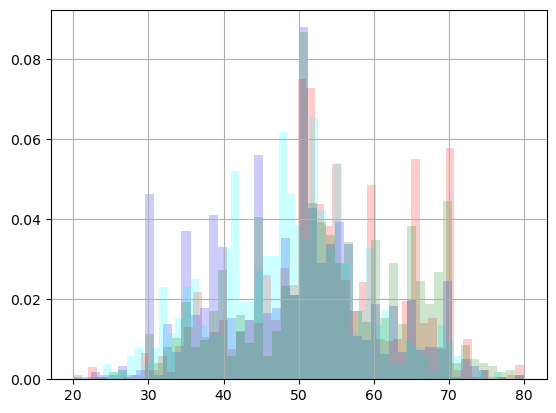

In [455]:
DataBase['chanceCreationShooting'].hist(bins=50, density=True, color='red', alpha=0.2)
DataBase['buildUpPlayPassing'].hist(bins=50, density=True, color='blue', alpha=0.2)
DataBase['buildUpPlayDribbling'].hist(bins=50, density=True, color='aqua', alpha=0.2)
DataBase['chanceCreationCrossing'].hist(bins=50, density=True, color='green', alpha=0.2)
plt.show()

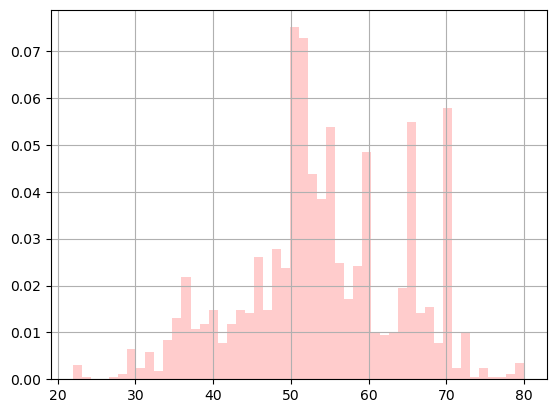

In [456]:
DataBase['chanceCreationShooting'].hist(bins=50, density=True, color='red', alpha=0.2)
plt.show()

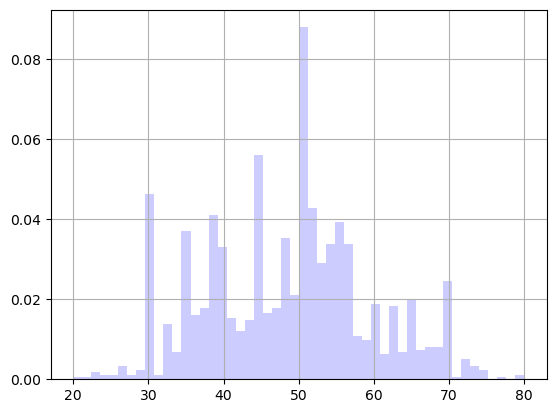

In [457]:
DataBase['buildUpPlayPassing'].hist(bins=50, density=True, color='blue', alpha=0.2)
plt.show()

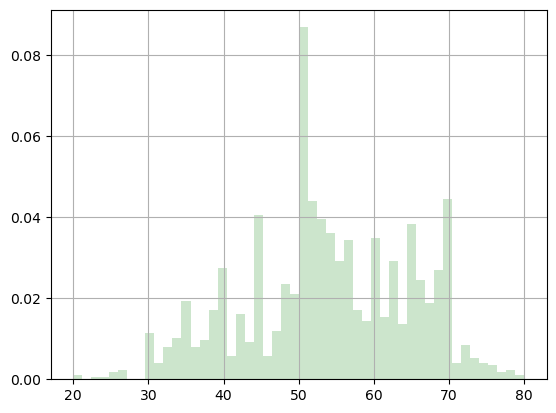

In [458]:
DataBase['chanceCreationCrossing'].hist(bins=50, density=True, color='green', alpha=0.2)
plt.show()

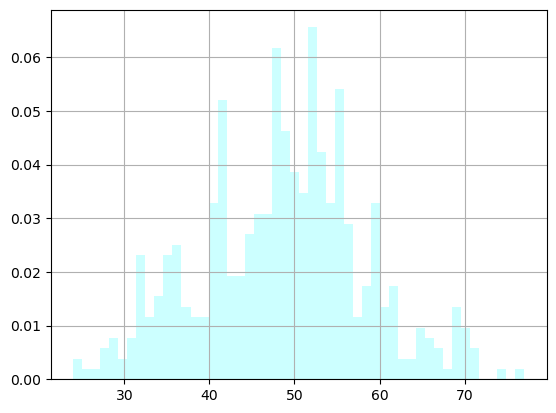

In [459]:
DataBase['buildUpPlayDribbling'].hist(bins=50, density=True, color='aqua', alpha=0.2)
plt.show()

### Hacemos  el test Train y Test utilizando el 'id' y 'chanceCreationShooting' 

# 3) Seleccion de Variables

In [460]:
## Se eliminaran las siguientes columnas
columnas_a_eliminar = ['buildUpPlayPositioningClass', 'defenceTeamWidthClass','defenceTeamWidth','defenceDefenderLineClass','date']
df = DataBase.drop(columns=columnas_a_eliminar)

In [461]:
df.head()

,id,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass
0,1,60,Balanced,NaN,Little,50,Mixed,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press
1,2,52,Balanced,48.0,Normal,56,Mixed,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press
2,3,47,Balanced,41.0,Normal,54,Mixed,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press
3,4,70,Fast,NaN,Little,70,Long,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double
4,5,47,Balanced,NaN,Little,52,Mixed,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press


In [462]:
def contar_valores(columnas, dataframe):
    resultados = {}
    for columna in columnas:
        conteo = dataframe[columna].value_counts()
        resultados[columna] = conteo
    return resultados



In [463]:
columnas_seleccionadas = ['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass','buildUpPlayPassingClass','chanceCreationShootingClass','chanceCreationPositioningClass', 'defencePressureClass','defenceAggressionClass', 'chanceCreationCrossingClass', 
                          'chanceCreationPassingClass']
valores_contados = contar_valores(columnas_seleccionadas, df)

for columna, conteo in valores_contados.items():
    print(f"Valores contados para la columna '{columna}':")
    print(conteo)
    print()

Valores contados para la columna 'buildUpPlaySpeedClass':
Balanced    1184
Fast         172
Slow         102
Name: buildUpPlaySpeedClass, dtype: int64

Valores contados para la columna 'buildUpPlayDribblingClass':
Little    1004
Normal     433
Lots        21
Name: buildUpPlayDribblingClass, dtype: int64

Valores contados para la columna 'buildUpPlayPassingClass':
Mixed    1236
Short     128
Long       94
Name: buildUpPlayPassingClass, dtype: int64

Valores contados para la columna 'chanceCreationShootingClass':
Normal    1224
Lots       197
Little      37
Name: chanceCreationShootingClass, dtype: int64

Valores contados para la columna 'chanceCreationPositioningClass':
Organised    1309
Free Form     149
Name: chanceCreationPositioningClass, dtype: int64

Valores contados para la columna 'defencePressureClass':
Medium    1243
Deep       154
High        61
Name: defencePressureClass, dtype: int64

Valores contados para la columna 'defenceAggressionClass':
Press      1274
Double       99

# 4) Ingeniería de características: deberá desarrollar todo el procedimiento de ingeniería  de  características  que  considere  necesario  para  resolver  el problema de predicción

In [464]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['id', 'chanceCreationShooting'],axis=1),
                                                    df['chanceCreationShooting'],
                                                    test_size=0.3,
                                                    random_state=2023)

In [465]:
#Imputación de variables numéricas
NUMERICAL_VARS_WITH_NA = ['buildUpPlayDribbling']

#Variables para transfomraicón logarítmica
NUMERICAL_LOG_VARS = ["buildUpPlaySpeed", "buildUpPlayDribbling", "buildUpPlayPassing","chanceCreationPassing","chanceCreationCrossing","defencePressure","defenceAggression"]

#Variables para codificación ordinal.
QUAL_VARS = ['chanceCreationCrossingClass','chanceCreationShootingClass','buildUpPlayDribblingClass']


#Variables para codificación por frecuencia (no ordinal)
###CATEGORICAL_VARS = ['defenceAggressionClass',  'defencePressureClass',  'chanceCreationPositioningClass',  'chanceCreationPassingClass',
###                    'buildUpPlayPassingClass', 'buildUpPlaySpeedClass']

defenceAggressionClass_VARS = ['defenceAggressionClass']
defencePressureClass_VARS = ['defencePressureClass']
chanceCreationPositioningClass_VARS = ['chanceCreationPositioningClass']
chanceCreationPassingClass_VARS = ['chanceCreationPassingClass']
buildUpPlayPassingClass_VARS = ['buildUpPlayPassingClass']
buildUpPlaySpeedClass_VARS = ['buildUpPlaySpeedClass']


#Mapeo para varibels categótricas para calidad.
QUAL_MAPPINGS = {'Lots': 1, 'Normal': 2, 'Little': 3}

defenceAggressionClass_MAPPINGS = {'Press': 1, 'Double': 2, 'Contain': 3}

defencePressureClass_MAPPINGS = {'Medium': 1, 'Deep': 2, 'High': 3}

chanceCreationPositioningClass_MAPPINGS = {'Organised': 1, 'Free Form': 2}

chanceCreationPassingClass_MAPPINGS = {'Normal': 1, 'Risky': 2, 'Safe': 3}

buildUpPlayPassingClass_MAPPINGS = {'Mixed': 1, 'Short': 2, 'Long': 3}

buildUpPlaySpeedClass_MAPPINGS = {'Balanced': 1, 'Fast': 2, 'Slow': 3}


#Mapeo para varibels categótricas para calidad.
QUAL_MAPPINGS = {'Lots': 1, 'Normal': 2, 'Little': 3}
#Variables a utilzar en el entrenamiento
FEATURES = [
    'buildUpPlaySpeed',
    'buildUpPlaySpeedClass',
    'buildUpPlayDribbling',
    'buildUpPlayDribblingClass',
    'buildUpPlayPassing',
    'buildUpPlayPassingClass',
    'chanceCreationPassing',
    'chanceCreationPassingClass',
    'chanceCreationCrossing',
    'chanceCreationCrossingClass',
    'chanceCreationShootingClass',
    'chanceCreationPositioningClass',
    'defencePressure',
    'defencePressureClass',
    'defenceAggression',
    'defenceAggressionClass',
]

In [466]:
X_train = X_train[FEATURES]

In [467]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [468]:
import myPreprocessorsPF as mypp

In [469]:
ProyectoFinal_pipeline_v123 = Pipeline([
    #==========Imputaciones====================

    ('missing_indicator_numeric',
        AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)
    ),
    

    ('mean_imputation',
        MeanMedianImputer(imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    ),

    #Codificacion de variables categoricas
    ('quality_mapper',
                mypp.Mapper(variables=QUAL_VARS,
                            mappings=QUAL_MAPPINGS)),

    ('defenceAggressionClass',
                mypp.Mapper(variables=defenceAggressionClass_VARS,
                            mappings=defenceAggressionClass_MAPPINGS)),
    
    ('defencePressureClass',
                mypp.Mapper(variables=defencePressureClass_VARS,
                            mappings=defencePressureClass_MAPPINGS)),

    ('chanceCreationPositioningClass',
                mypp.Mapper(variables=chanceCreationPositioningClass_VARS,
                            mappings=chanceCreationPositioningClass_MAPPINGS)),
    
    ('chanceCreationPassingClass',
                mypp.Mapper(variables=chanceCreationPassingClass_VARS,
                            mappings=chanceCreationPassingClass_MAPPINGS)),

    ('buildUpPlayPassingClass',
                mypp.Mapper(variables=buildUpPlayPassingClass_VARS,
                            mappings=buildUpPlayPassingClass_MAPPINGS)),

    ('buildUpPlaySpeedClass',
                mypp.Mapper(variables=buildUpPlaySpeedClass_VARS,
                            mappings=buildUpPlaySpeedClass_MAPPINGS)),

    
    ('log_tansform',
        LogTransformer(variables=NUMERICAL_LOG_VARS)),

    #Feature Scalling
    ('scaler',
        MinMaxScaler()
    ),
    
    ('modelo_lasso', 
         Lasso(alpha=0.01, random_state=2022)
    )


])

In [470]:
ProyectoFinal_pipeline_v123.fit(X_train, y_train)

Pipeline(steps=[('missing_indicator_numeric',
                 AddMissingIndicator(variables=['buildUpPlayDribbling'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['buildUpPlayDribbling'])),
                ('quality_mapper',
                 Mapper(mappings={'Little': 3, 'Lots': 1, 'Normal': 2},
                        variables=['chanceCreationCrossingClass',
                                   'chanceCreationShootingClass',
                                   'buildUpPla...
                 Mapper(mappings={'Balanced': 1, 'Fast': 2, 'Slow': 3},
                        variables=['buildUpPlaySpeedClass'])),
                ('log_tansform',
                 LogTransformer(variables=['buildUpPlaySpeed',
                                           'buildUpPlayDribbling',
                                           'buildUpPlayPassing',
                                           'chanceCreatio

# 5) Desarrollo de modelo de clasificación

In [471]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import joblib

In [472]:
X_test = X_test[FEATURES]

In [473]:
preds = ProyectoFinal_pipeline_v123.predict(X_test)

### RMSE que poseemos para el test

In [474]:
rmseTest = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds)))
rmseTest

7.715500664335233

### Mejorar el RMSE 

In [475]:
np.min(np.exp(y_train)), np.max(np.exp(y_train))

(22.000000000000004, 79.99999999999997)

In [476]:
rmseTest / (np.max(np.exp(y_train)) - np.min(np.exp(y_train)))

0.1330258735230213

In [477]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [478]:
X = df.drop(['chanceCreationShooting','id'], axis=1)
y = df['chanceCreationShooting']

In [479]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=2023)

In [480]:
variables_categoricas = ['buildUpPlayDribbling','defenceAggressionClass',  'defencePressureClass',  'chanceCreationPositioningClass',  'chanceCreationPassingClass',
                         'buildUpPlayPassingClass', 'buildUpPlaySpeedClass','chanceCreationCrossingClass','chanceCreationShootingClass','buildUpPlayDribblingClass']  

# Realizar la codificación one-hot
data_encoded = pd.get_dummies(df, columns=variables_categoricas)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data_encoded.drop('chanceCreationShooting', axis=1), data_encoded['chanceCreationShooting'], test_size=0.2, random_state=42)

# Escalar los datos utilizando StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### LogisticRegression

In [481]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train_std, y_train)

logit_preds = logit.predict(X_test_std)
logit_preds

c:\Users\Jose L\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([50, 52, 52, 70, 59, 50, 32, 53, 50, 48, 50, 53, 60, 52, 44, 55, 50,
       58, 60, 52, 47, 50, 53, 70, 66, 35, 54, 65, 47, 53, 36, 56, 55, 55,
       50, 47, 53, 50, 50, 50, 35, 54, 53, 50, 68, 56, 70, 47, 70, 67, 46,
       70, 44, 49, 48, 55, 35, 50, 53, 50, 59, 67, 55, 46, 49, 60, 70, 55,
       32, 52, 53, 50, 50, 60, 50, 49, 46, 53, 40, 23, 48, 40, 52, 39, 60,
       41, 50, 50, 50, 53, 50, 50, 43, 47, 60, 57, 60, 50, 49, 64, 53, 34,
       65, 68, 50, 47, 53, 53, 47, 67, 50, 52, 50, 60, 40, 53, 52, 50, 56,
       68, 68, 76, 50, 34, 50, 70, 53, 53, 67, 58, 65, 70, 50, 50, 50, 50,
       67, 40, 53, 68, 59, 52, 67, 50, 50, 70, 50, 46, 50, 68, 53, 57, 59,
       37, 36, 58, 50, 46, 54, 53, 52, 50, 50, 44, 50, 70, 51, 64, 50, 60,
       50, 54, 67, 65, 52, 65, 72, 52, 50, 50, 56, 70, 50, 58, 53, 40, 35,
       32, 44, 66, 65, 55, 50, 46, 53, 68, 56, 59, 48, 53, 60, 50, 52, 53,
       50, 46, 70, 52, 52, 50, 68, 53, 54, 50, 57, 69, 50, 39, 70, 40, 58,
       70, 50, 53, 59, 48

In [482]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming you have X_train, X_test, y_train, y_test as your training and test data

# Create an instance of Logistic Regression
logreg = LogisticRegression()

# Fit the model on the training data
logreg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.08561643835616438


c:\Users\Jose L\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### roc_auc_score NO se logro obtener

In [502]:
from sklearn.metrics import roc_auc_score

y_scores = logit.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_scores, multi_class='ovr')
acc = round(accuracy_score(y_test, logit_preds),5)

c:\Users\Jose L\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

### Optimizacion de parametros GridSearchCV, KFold

In [484]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

param_grid = {'C': [0.1, 1.0, 10.0],
              'penalty': ['l1', 'l2']}

logistic_model = LogisticRegression()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(logistic_model, param_grid, cv=kfold, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Mejores hiperparámetros:", best_params)
print("Accuracy:", accuracy)

c:\Users\Jose L\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Jose L\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Mejores hiperparámetros: {'C': 10.0, 'penalty': 'l2'}
Accuracy: 0.0821917808219178


c:\Users\Jose L\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [501]:
from sklearn.linear_model import LogisticRegression

best_model = LogisticRegression(C=10.0, penalty='l2')
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.0821917808219178
Precision: 0.03365688382712117
Recall: 0.0821917808219178
F1 Score: 0.04596719986386455


c:\Users\Jose L\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Jose L\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Optimizacion de Random Forest

### Y 6 Evaluar datos dado la matriz de confucion

In [500]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Imprimir los resultados
print("Confusion Matrix:")
print(confusion_mat)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Precision: 0.4083083375045214
Recall: 0.3972602739726027
Accuracy: 0.3972602739726027
F1 Score: 0.37415747433293156


c:\Users\Jose L\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jose L\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


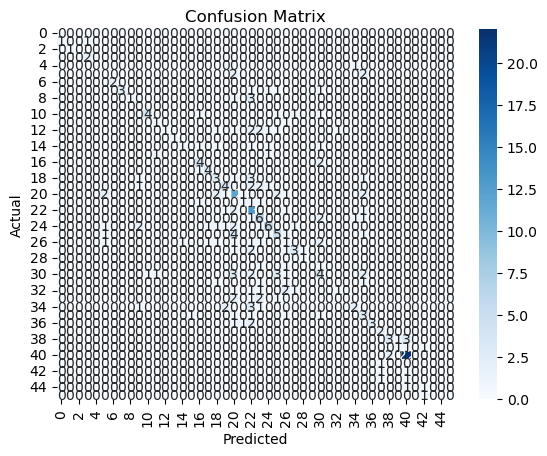

In [489]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()